In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
os.chdir("..")
from Source.Models.autoregGMM import AutoRegGMM
import Source.Util.preprocessing as prep
from Source.Util.util import load_params, get, get_device
import torch
from torch.utils.data import DataLoader
from Source.Util.simulateToyData import ToySimulator

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
runpath = "runs/AutoRegGMM_toy_7980/" #flat
#runpath = "runs/AutoRegGMM_toy_2408/" #gaussian sphere

# Load data

In [3]:
modelpath = runpath + "models/model_run0.pt"
parampath = runpath + "paramfile.yaml"
params = load_params(parampath)
params["device"]=get_device()

FileNotFoundError: [Errno 2] No such file or directory: 'runs/AutoRegGMM_toy_7980/paramfile.yaml'

In [4]:
data = ToySimulator(params).data
n_gauss = params["n_gauss"]

NameError: name 'params' is not defined

# Initialize modified model class

In [5]:
model = AutoRegGMM(params)
state_dict = torch.load(modelpath, map_location=params["device"])
model.load_state_dict(state_dict)

Build model AutoRegGMM with n_head=2, n_per_head=16, n_blocks=2, intermediate_fac=2, n_gauss=5 with bayesian=0


<All keys matched successfully>

In [6]:
data_split = params["data_split"]
n_data = len(data)
cut1 = int(n_data - data_split[0])
model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)

# Generate samples

In [7]:
n_samples = 10
samples, xs, probs, probsindiv = model.sample_n_bonus(n_samples)
samples = samples[:,1:]

print(samples)
print(np.shape(probs), np.shape(xs), np.shape(probsindiv), np.shape(samples), np.shape(data))

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


[[-1.0889834   0.08187315]
 [ 0.28576165  1.0060037 ]
 [-0.92276126  0.61639583]
 [-0.7220197  -0.5061687 ]
 [ 0.1370757  -1.0616962 ]
 [ 0.8877385   0.54188067]
 [-0.83101106  0.6639548 ]
 [ 0.08824918 -1.1620791 ]
 [-0.66624576  0.51845545]
 [ 0.5369706   0.830467  ]]
(10, 2, 1000) (2, 1000) (10, 2, 5, 1000) (10, 2) (1000000, 2)


# Test plot

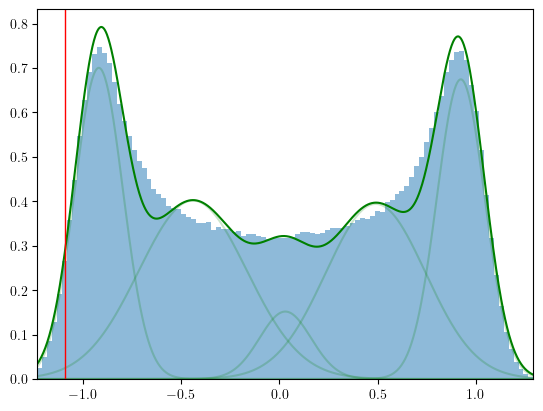

In [8]:
idim=0
isample=0
bins=100
xmin=np.min(xs[idim,:])
xmax=np.max(xs[idim,:])
plt.hist(data[:,idim], alpha=.5, bins=bins, range=(xmin, xmax), density=True, align="mid", rwidth=1.)
plt.plot(xs[idim,:], probs[isample, idim, :], color="g")
for igauss in range(n_gauss):
    plt.plot(xs[idim,:], probsindiv[isample,idim,igauss,:], color="g", linestyle="-", alpha=.2)
_, ymax = plt.ylim()
plt.vlines(samples[isample,idim], 0., ymax, "r", linewidth=1)
plt.xlim(xmin, xmax)
plt.ylim(0., ymax)
plt.show()

TBD
- Plot also the individual gaussians (nicer)

# Fancy plot

In [9]:
def probPlot(probs, samples, filenameOut=None, var=None, maxSamples=None, nbins=100):
    nsamples = np.shape(samples)[0]
    if(maxSamples!=None):
       nsamples = np.min([nsamples, maxSamples])
    ndim = np.shape(samples)[1]
    f, axarr = plt.subplots(nsamples, ndim, figsize=(3*ndim,3*nsamples), sharex=True,
                           gridspec_kw={"hspace": 0.})
    plt.tight_layout()
    
    ymax=np.zeros(ndim)
    for isample in range(nsamples):
        print(f"Working on sample {isample}/{nsamples}")
        for idim in range(ndim):
            xmin=xs[idim,0]
            xmax=xs[idim,-1]
            
            axarr[isample,idim].plot(xs[idim,:], probs[isample,idim,:], color="g")
            axarr[isample,idim].hist(data[:,idim], density=True, alpha=.5, range=(xmin, xmax), rwidth=1., bins=nbins, align="mid")
            for igauss in range(n_gauss):
                axarr[isample,idim].plot(xs[idim,:], probsindiv[isample,idim,igauss,:], color="g", alpha=.2)
            _, ymax0 = axarr[isample,idim].get_ylim()

            ymax[idim] = np.max([ymax[idim], ymax0])
            axarr[isample,idim].vlines(samples[isample,idim], 0., ymax[idim], color="r")
            if((type(var) is np.ndarray) and isample==nsamples-1):
                axarr[isample,idim].set_xlabel(r"${%s}$ bin" %var[idim])
    for isample in range(nsamples):
        for idim in range(ndim):
            xmin=xs[idim,0]
            xmax=xs[idim,-1]
            axarr[isample,idim].set_ylim(0, ymax[idim])
            #axarr[isample,idim].set_xlim(xmin, xmax)
    if(filenameOut!=None):
        f.savefig(filenameOut, format="pdf", bbox_inches="tight")
    #plt.close()

Working on sample 0/5
Working on sample 1/5
Working on sample 2/5
Working on sample 3/5
Working on sample 4/5


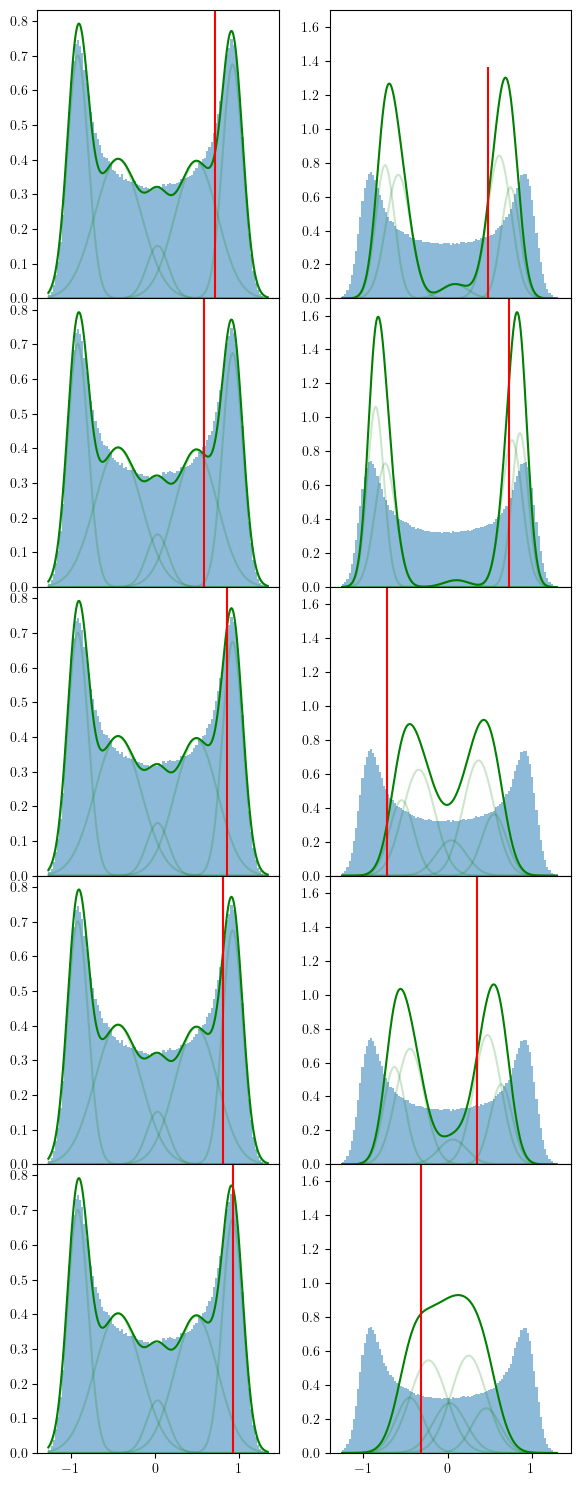

In [10]:
probPlot(probs, samples, var=None, maxSamples=5, filenameOut="test.pdf")

# Compute likelihood

In [9]:
prec = 500
xmin = -1.5
xmax = 1.5
x0 = np.linspace(xmin, xmax, prec)
def getGrid(xmin, xmax, prec):
    x, y = np.meshgrid(np.linspace(xmin, xmax, prec), np.linspace(xmin, xmax, prec))
    base = np.stack([x.ravel(), y.ravel()], -1)
    return x, y, base
x, y, base = getGrid(xmin, xmax, prec)
base = torch.from_numpy(base).float()
_, likelihood, _, _, _ = model.batch_loss(base, getMore=True)
likelihood = likelihood.detach().numpy()
likelihoodArr = likelihood.reshape((prec, prec))

# Likelihood contourf plot

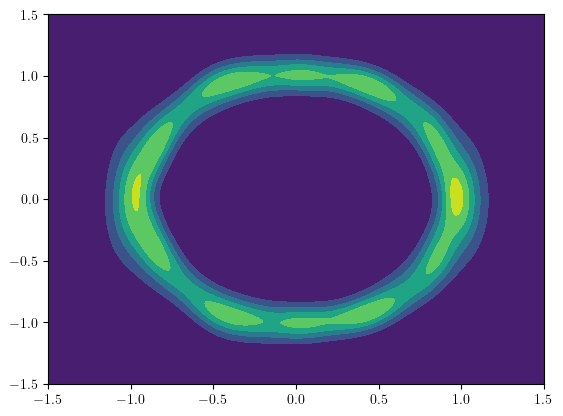

In [10]:
plt.contourf(x, y, likelihoodArr)
plt.savefig("test2.pdf", bbox_inches="tight")
plt.show()

# Marginal likelihoods

In [11]:
def marginalize(x, likelihood, dim):
    likelihood2 = np.swapaxes(likelihood, dim, 0)
    marg = np.trapz(likelihood2, x=x, axis=0)
    return marg
marginal1 = marginalize(x0, likelihoodArr, 0)
marginal2 = marginalize(x0, likelihoodArr, 1)
norm = marginalize(x0, marginal1, 0)
print(f"Check: normalization = {norm:.10f}")

Check: normalization = 0.9999726848


In [12]:
n_samples = 1000000
samples = model.sample_n(n_samples)

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Sampling time estimate: 6.73 s = 0.11 min


In [13]:
def gauss(x, mu, sigma):
    return 1/(2*np.pi*sigma**2)**.5 * np.exp(-(x-mu)**2/(2*sigma**2))
def getKDE(x, samples, sigma=.03): #.01 for ramp
    ret = np.zeros_like(x)
    n = len(samples)
    for i in range(n):
        ret += 1/n * gauss(x, samples[i], sigma)
    return ret
        
data_f = np.zeros((np.shape(marginal1)[0], 2))
for i in range(2):
    data_f[:,i] = getKDE(x0, data[:,i])

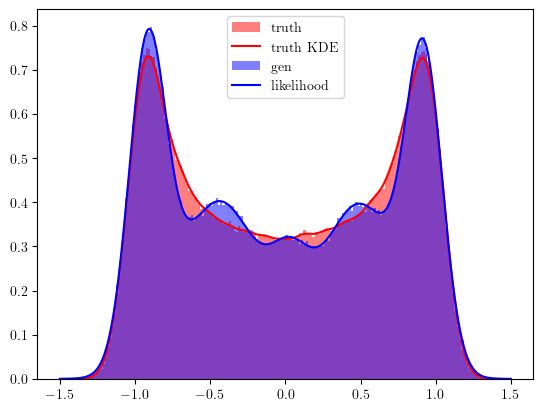

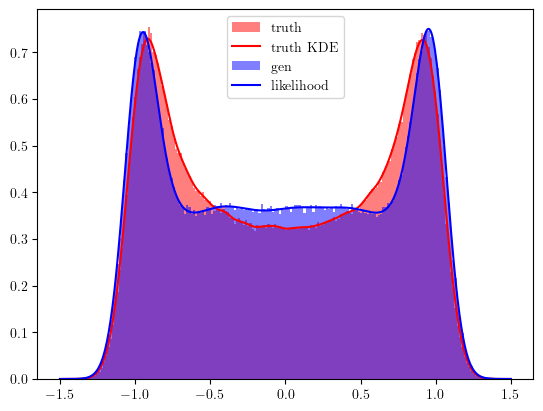

In [14]:
nbins = 200
plt.hist(data[:,0], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="r", label="truth")
plt.plot(x0, data_f[:,0], label="truth KDE", color="r")
plt.hist(samples[:,0], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="gen")
plt.plot(x0, marginal1, label="likelihood", color="b")
plt.legend()
plt.savefig("test3.pdf", bbox_inches="tight")
plt.show()

_, bins, _ = plt.hist(data[:,1], density=True, range=(xmin, xmax), bins=nbins, alpha=.5, color="r", label="truth")
plt.plot(x0, data_f[:,1], label="truth KDE", color="r")
plt.hist(samples[:,1], density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="gen")
plt.plot(x0, marginal2, label="likelihood", color="b")
plt.legend()
plt.savefig("test4.pdf", bbox_inches="tight")
plt.show()

# Marginal R distribution

In [15]:
Rmin = 1e-2
Rmax = 2.
xmin = -1.5
xmax = 1.5
R0 = np.linspace(Rmin, Rmax, prec)
marginalR = np.zeros_like(R0)
for i in range(prec):
    R = R0[i]
    x2 = np.linspace(np.max([xmin, -(R-1e-3)]), np.min([xmax, (R-1e-3)]), prec)
    x1 = (R**2 - x2**2)**.5
    base = np.zeros((prec, 2))
    base[:,0] = x1
    base[:,1] = x2
    base = torch.from_numpy(base).float()
    _, likelihood, _, _, _ = model.batch_loss(base, getMore=True)
    likelihood = likelihood.detach().numpy()
    likelihood = likelihood * 2*R/(R**2-x2**2)**.5
    marginalR[i] = marginalize(x2, likelihood, 0)
norm = marginalize(R0, marginalR, 0)
likelihood /= norm #ensure normalization
print(f"Check: normalization = {norm:.10f}")
#print(R0)

Check: normalization = 0.9682156561


In [16]:
samplesR = (samples[:,0]**2 + samples[:,1]**2)**.5
R_f = np.zeros((np.shape(marginal1)[0], 2))
for i in range(2):
    R_f[:,i] = getKDE(R0, samplesR)

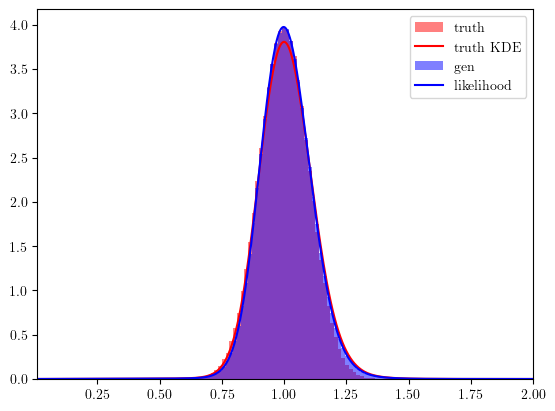

In [44]:
plt.hist((data[:,0]**2+data[:,1]**2)**.5, density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="r", label="truth")
plt.plot(R0, R_f[:,0], label="truth KDE", color="r")
plt.hist(samplesR, density=True, bins=nbins, range=(xmin, xmax), alpha=.5, color="b", label="gen")
plt.plot(R0, marginalR, label="likelihood", color="b")
plt.legend()
plt.xlim(Rmin, Rmax)
plt.savefig("test5.pdf", bbox_inches="tight")
plt.show()

# Marginal R and phi distributions

In [40]:
Rmin = 1e-2
Rmax = 2.
phimin = 0.
phimax = 2*np.pi
R0 = np.linspace(Rmin, Rmax, prec)
phi0 = np.linspace(phimin, phimax, prec)
R, phi = np.meshgrid(np.linspace(Rmin, Rmax, prec), np.linspace(phimin, phimax, prec))
x1 = R*np.cos(phi)
x2 = R*np.sin(phi)
base = np.stack([x1.ravel(), x2.ravel()], -1)
base = torch.from_numpy(base).float()
_, likelihood, _, _, _ = model.batch_loss(base, getMore=True)
likelihood = likelihood.detach().numpy()
likelihoodArr = likelihood.reshape((prec, prec)) *R
marginalR = marginalize(phi0, likelihoodArr, 0)
marginalphi = marginalize(R0, likelihoodArr, 1)
normR = marginalize(R0, marginalR, 0)
print(f"Check: R normalization = {normR:.10f}")
normphi = marginalize(phi0, marginalphi, 0)
print(f"Check: phi normalization = {normphi:.10f}")

Check: R normalization = 0.9999980540
Check: phi normalization = 0.9999980540


In [55]:
def getR(samples):
    return (samples[:,0]**2 + samples[:,1]**2)**.5
def getphi(samples):
    return ( 2*np.arctan2(samples[:,1], samples[:,0]+getR(samples)) +2*np.pi) % (2*np.pi)

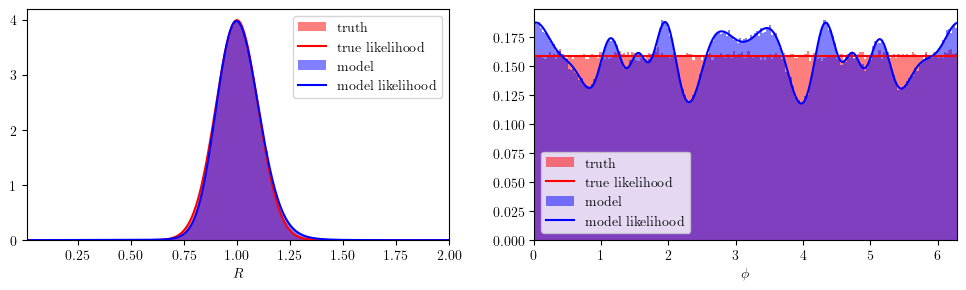

In [67]:
fig = plt.figure(figsize=(12,3))
fig.add_subplot(1,2,1)
plt.hist(getR(data), density=True, bins=nbins, range=(Rmin, Rmax), alpha=.5, color="r", label="truth")
plt.plot(R0, 1/(2*np.pi*.1**2)**.5 * np.exp(-(R0-1.)**2/(2*.1**2)), color="r", label="true likelihood")
plt.hist(getR(samples), density=True, bins=nbins, range=(Rmin, Rmax), alpha=.5, color="b", label="model")
plt.plot(R0, marginalR, label="model likelihood", color="b")
plt.legend()
plt.xlim(Rmin, Rmax)
plt.xlabel(r"$R$")

fig.add_subplot(1,2,2)
plt.hist(getphi(data), density=True, bins=nbins, range=(phimin, phimax), alpha=.5, color="r", label="truth")
plt.plot(phi0, 1/(2*np.pi)+0*phi0, color="r", label="true likelihood")
plt.hist(getphi(samples), density=True, bins=nbins, range=(phimin, phimax), alpha=.5, color="b", label="model")
plt.plot(phi0, marginalphi, label="model likelihood", color="b")
plt.legend()
plt.xlim(phimin, phimax)
plt.xlabel(r"$\phi$")
plt.savefig("test6.pdf", bbox_inches="tight")
plt.show()